# Module 8

Much research has been conducted regarding tornado-related fatalities in the US
and their spatiotemporal patterns. Ashley (2007) found that the Southeast US is
especially vulnerable to tornadoes and hypothesized a number of factors that 
may be behind this. These include:
- Number of significant tornadoes
- Number of mobile homes
- Large percentage of nighttime tornadoes
- Large percentage of cool and "transition" season tornadoes
- Higher population density
- "Other human vulnerabilities"

Several of these factors have been studied in more detail in subsequent papers,
including nighttime tornadoes (Strader et al. 2022) and mobile home 
vulnerability (Strader and Ashley 2018) amongst many others. However, it does 
not appear that any study has combined all of the above factors to determine 
which are the greatest contributors to tornado fatalities.

This analysis will attempt to use a database of tornadoes from 2007-present and
socioeconomic data from the CDC to look at these various factors that are
thought to contribute to tornado vulnerability. Using a machine learning
approach, the relative importance of each of these factors will be analyzed in 
an attempt to show which contribute the most to a region's vulnerability.

## Part 1: Dataset Analysis

We will begin by downloading the various datasets and analyzing relationships 
between a few of the interesting variables.

In [2]:
# Import packages
import numpy as np
import urllib.request
import pandas as pd 
import requests, zipfile, io
from datetime import datetime, timedelta, timezone
from zipfile import ZipFile
from bs4 import BeautifulSoup
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# Read in NCEI tornado data
# Adapted from hail data code originally created by Seth Goodnight

dir_url = 'https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles'
ext = '.csv.gz'

def listFD(url, ext=''):
    page = requests.get(url).text
    #print(file)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

# The years we want to analyze
year_list = [str(i) for i in range(2007,2023)]

li = []

for file in listFD(dir_url, ext):
    if any(year in file[:98] for year in year_list) & ('details' in file):
        print(file)
        df = pd.read_csv(file)#, compression = 'gzip'), #index_col=None, )
       
        hail_df = pd.DataFrame(df.loc[df['EVENT_TYPE'] == 'Tornado'])
        li.append(hail_df)
df_tor = pd.concat(li, axis=0, ignore_index=True)  

hail_datetimes = np.array([])

offset = [int(i.split('-')[1]) for i in df_tor['CZ_TIMEZONE']]


for i in range(0,len(df_tor['BEGIN_TIME'])):
    mtime        = str(np.array(df_tor['BEGIN_TIME'])[i])
    if len(mtime)<4:
        nz = 4 - len(mtime)
        nZ = '0'*nz
        mtime = nZ + mtime
    check_date = datetime(int(str(np.array(df_tor['BEGIN_YEARMONTH'])[i])[:4]), \
                     int(str(np.array(df_tor['BEGIN_YEARMONTH'])[i])[-2:]), \
                     int(str(np.array(df_tor['BEGIN_DAY'])[i])),           \
                     int(mtime[:-2]),     \
                     int(mtime[-2:])) + timedelta(hours = offset[i])
    hail_datetimes = np.append(hail_datetimes, check_date)

df_tor['Datetime'] = hail_datetimes
df_tor = df_tor.sort_values(by=['Datetime'], ignore_index = True)

https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2007_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2008_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2009_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2010_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2011_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2012_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2013_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2014_c20221018.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2015_

In [4]:
# Drop any tornadoes rated as EFU as these are difficult to handle numerically
df_tor_drop = df_tor
df_tor_drop.drop(df_tor.index[df_tor['TOR_F_SCALE'] == 'EFU'], inplace=True)
df_tor_drop.reset_index(drop=True, inplace=True)

# Create New EF Scale integer column to replace the string column
test=[]
for i in range(0, len(df_tor_drop.TOR_F_SCALE), 1):
    if len(df_tor_drop.TOR_F_SCALE[i])==3:
        temp = df_tor_drop.TOR_F_SCALE[i][2:]
    else: # Accounts for old F scale ratings
        temp = df_tor_drop.TOR_F_SCALE[i][1:]
    temp = int(temp)
    test.append(temp)

df_tor_drop['EF_Rate']=test

In [5]:
# Read in the CDC vulnerability dataset
cdc = pd.read_csv('SVI2018_US_COUNTY.csv')

In order to combine our two datasets, we need to have a column along which we
can perform a join. Both datsets include FIPS codes; however, our tornado
dataset has these split into two values, one for the state and one for the 
county. Here we will combine these into the full FIPS code as used in the CDC
dataset.

In [6]:
# Create full FIPS codes for tornado dataset
test1 = []
for i in range(0, len(df_tor_drop.CZ_FIPS), 1):
    val1 = str(df_tor_drop.CZ_FIPS[i])
    val2 = str(df_tor_drop.STATE_FIPS[i])
    if df_tor_drop.CZ_FIPS[i]<100:
        temp1 = val2+'0'+val1
        temp2 = int(temp1)
    else:
        temp1 = val2+val1
        temp2 = int(temp1)
    test1.append(temp2)

# Create a copy of the datframe with an added column with full FIPS codes
df_tor_fips = df_tor_drop
df_tor_fips['FIPS'] = test1

In [505]:
# Merge the two datasets along the FIPS column
df_cdc = pd.merge(df_tor_fips, cdc, how="left", on=["FIPS"])

In [506]:
# Trim down our dataset by making a copy and only selecting relevant columns
cdc_test = df_cdc[['BEGIN_TIME', 'DEATHS_DIRECT', 'EF_Rate', 
                    'EP_MOBILE', 'BEGIN_YEARMONTH', 'E_TOTPOP', 'AREA_SQMI'
                    ]].copy()

# Drop rows that do not contain values in these relevant columns
cdc_test = cdc_test[cdc_test['DEATHS_DIRECT'].notna()]
cdc_test = cdc_test[cdc_test['DEATHS_DIRECT']!=-999.0]

cdc_test = cdc_test[cdc_test['EP_MOBILE'].notna()]
cdc_test = cdc_test[cdc_test['EP_MOBILE']!=-999.0]

cdc_test = cdc_test[cdc_test['E_TOTPOP'].notna()]
cdc_test = cdc_test[cdc_test['E_TOTPOP']!=-999.0]

cdc_test = cdc_test[cdc_test['AREA_SQMI'].notna()]
cdc_test = cdc_test[cdc_test['AREA_SQMI']!=-999.0]

# cdc_test = cdc_test[cdc_test['RPL_THEMES'].notna()]
# cdc_test = cdc_test[cdc_test['RPL_THEMES']!=-999.0]

In [507]:
# Replace each fatality value with a 1 or 0 depending on if there was a 
# fatality.
fatals = []
for i in cdc_test.DEATHS_DIRECT:
    if i>= 1:
        f = 1
    else:
        f= 0
    fatals.append(f)

# Create a new column for these values and delete the deaths column
cdc_test['Fatalities'] = fatals
cdc_test = cdc_test.drop('DEATHS_DIRECT', axis=1)

In [508]:
# Calculate population density of each county by dividing the total population
# by the area of the county
den = []
den = cdc_test.E_TOTPOP/cdc_test.AREA_SQMI
cdc_test['Density']=den
cdc_test = cdc_test.drop('E_TOTPOP', axis=1)
cdc_test = cdc_test.drop('AREA_SQMI', axis=1)

In [509]:
# Perform a one hot encoding of season from the month data. This results in
# four columns containing ones and zeros, one for each season.
months = []
cold = []
for i in range(0, len(cdc_test), 1):
    temp = str(int(cdc_test.BEGIN_YEARMONTH.iloc[[i]]))[-2:]
    months.append(temp)

for i in range(0, len(months), 1):
    temp2 = months[i]
    temp2 = int(temp2)
    if temp2==12 or temp2==1 or temp2==2:
        temp3 = 1
    else:
        temp3 = 0
    cold.append(temp3)

cdc_test['DJF'] = cold

months = []
cold = []
for i in range(0, len(cdc_test), 1):
    temp = str(int(cdc_test.BEGIN_YEARMONTH.iloc[[i]]))[-2:]
    months.append(temp)

for i in range(0, len(months), 1):
    temp2 = months[i]
    temp2 = int(temp2)
    if temp2==3 or temp2==4 or temp2==5:
        temp3 = 1
    else:
        temp3 = 0
    cold.append(temp3)

cdc_test['MAM'] = cold

months = []
cold = []
for i in range(0, len(cdc_test), 1):
    temp = str(int(cdc_test.BEGIN_YEARMONTH.iloc[[i]]))[-2:]
    months.append(temp)

for i in range(0, len(months), 1):
    temp2 = months[i]
    temp2 = int(temp2)
    if temp2==6 or temp2==7 or temp2==8:
        temp3 = 1
    else:
        temp3 = 0
    cold.append(temp3)

cdc_test['JJA'] = cold

months = []
cold = []
for i in range(0, len(cdc_test), 1):
    temp = str(int(cdc_test.BEGIN_YEARMONTH.iloc[[i]]))[-2:]
    months.append(temp)

for i in range(0, len(months), 1):
    temp2 = months[i]
    temp2 = int(temp2)
    if temp2==9 or temp2==10 or temp2==11:
        temp3 = 1
    else:
        temp3 = 0
    cold.append(temp3)

cdc_test['SON'] = cold
cdc_test = cdc_test.drop('BEGIN_YEARMONTH', axis=1)

In [510]:
# Perform a one hot encoding of the time of day (day vs night) with night
# defined as 10pm - 6am local time.
test = []
for i in cdc_test.BEGIN_TIME:
    if i <= 600:
        f = 1
    elif i >= 2200:
        f = 1
    else:
        f= 0
    test.append(f)

cdc_test['NIGHT'] = test

cdc_test = cdc_test.drop('BEGIN_TIME', axis=1)

In [511]:
# Print out the completed dataset
cdc_test

,EF_Rate,EP_MOBILE,Fatalities,Density,DJF,MAM,JJA,SON,NIGHT
0,1,20.7,1,126.618845,1,0,0,0,0
1,1,23.8,0,39.765338,1,0,0,0,0
2,1,21.9,0,98.521699,1,0,0,0,1
3,0,21.3,0,41.247223,1,0,0,0,1
4,1,23.1,0,37.248135,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
21280,0,13.3,0,3.533380,0,0,1,0,0
21281,2,7.6,0,68.435237,0,0,1,0,0
21283,1,2.4,0,1127.052949,0,0,1,0,0
21284,1,14.7,0,138.628707,0,0,1,0,0


## Part 2: Machine Learning and Feature Importances

Now, we'll begin making and experimenting with our machine learning model.
We'll be using a random forest regressor.

In [512]:
#Seperate our input data from our target data
X_cdc = cdc_test.drop('Fatalities', axis=1)
y_cdc = cdc_test['Fatalities']

In [513]:
# Split our data into a training dataset and a testing dataset
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_cdc, y_cdc,
                                                random_state=0, train_size=0.8)

In [514]:
# # Fit our random forest regressor to the training data
# from sklearn.ensemble import RandomForestRegressor

# forest = RandomForestRegressor(bootstrap=True, n_estimators=200, 
#             min_samples_leaf=4, min_samples_split=10, max_depth=10)
# forest.fit(Xtrain, ytrain)

In [515]:
# Fit our random forest regressor to the training data
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(bootstrap=True, n_estimators=200, 
            min_samples_leaf=4, min_samples_split=5, max_depth=5)
forest.fit(Xtrain, ytrain)

RandomForestRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=200)

In [516]:
# Create a set of predictions from our test data using the model
ypredict = forest.predict(Xtest)

In [517]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Calculate our r squared and RMSE values to compare how this models 
# predictions performed compared to the actual values.
R2 = r2_score(ytest, ypredict)
print(f'The correlation coefficient of the model is {R2}')
RMSE = (mean_squared_error(ytest, ypredict))**0.5
print(f'The RMSE of the model is {RMSE}')

The correlation coefficient of the model is 0.32115974974813344
The RMSE of the model is 0.10883133740978067


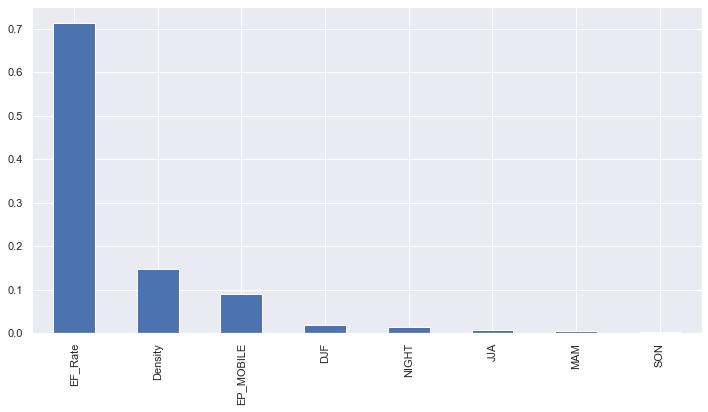

In [518]:
# Plot the feature importances of the random forest regressor
importances = pd.Series(forest.feature_importances_)
importances.index = X_cdc.columns
importances.sort_values(inplace=True, ascending=False)
importances.plot.bar(figsize=(12,6))
plt.show()

Unsurprisingly, the EF rate of a tornado is by far the most important factor in 
determining whether or not it will be fatal.

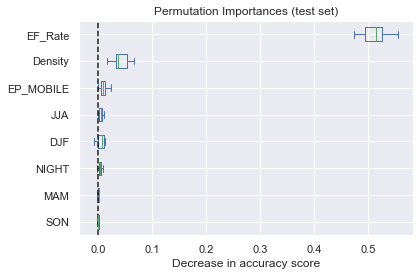

In [519]:
from sklearn.inspection import permutation_importance

# Plot the permutation importances of the model
result = permutation_importance(
    forest, Xtest, ytest, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_cdc.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

Similarly, looking at permutation importances, EF rate is by far the most 
important feature. Density is also important relative to the remaining 
categories, but is still far behind EF rate.

Now, we'll further explore feature importances using SHAP

In [520]:
import shap
shap.initjs()

In [521]:
# Generate SHAP values for our model
explainer = shap.Explainer(forest)
shap_test = explainer(Xtest)
shap_values = explainer.shap_values(X_cdc)

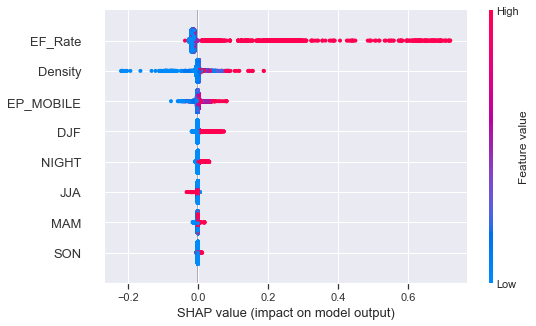

In [522]:
# Plot the SHAP summary plot, showing the importance and contribution of each 
# feature.
shap.summary_plot(shap_values, X_cdc)

Again we see that EF rate is the most important predictor. Density is ranked 
second, but there is substantial noise in the positive signal. It does, however, 
appear that low density will generally pull the prediction down. Percentage of 
mobile homes is ranked next but again has a somewhat noisy signal with higher 
percentages generally pulling the prediction up. The cool season (DJF) follows 
with a strong signal (events occurring in this month result in higher 
likelihood of fatalities) as does nighttime (again with events occurring in 
this category being more likely to cause fatalities). The summer season has a 
slight contribution in pulling predictions down and the remaining two seasons 
have very little clear impact.

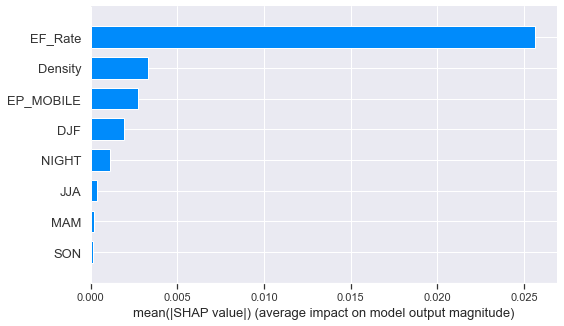

In [523]:
# Plot the SHAP summary plot as a simpler bar chart, showing just importances.
shap.summary_plot(shap_values, features=X_cdc.columns, plot_type='bar')

## Part 3: Testing the Model's Accuracy

In [635]:
# Create a simple binary dataset for whether the models prediction is correct 
# (1) or incorrect (0) based on an arbitrary threshold, w.
w = 0.5
ypredict_binary = []
for i in range(0, len(ypredict), 1):
    if ypredict[i]>=w:
        m = 1
    else:
        m = 0
    ypredict_binary.append(m)

In [636]:
# Reset the index of ytest
ytest_index = ytest.reset_index(drop=True)

In [637]:
# Create datasets to show when the model is accurate compared to the actual 
# outcome and whether incorrect instances are false predictions or missed 
# predictions.
test = []
how_wrong = []
for i in range(0, len(ytest), 1):
    if ytest_index[i]==0 and ypredict_binary[i]==0:
        m=1
        f=0
    elif ytest_index[i]==1 and ypredict_binary[i]==0:
        m=0
        f=1
    elif ytest_index[i]==0 and ypredict_binary[i]==1:
        m=0
        f=2
    elif ytest_index[i]==1 and ypredict_binary[i]==1:
        m=1
        f=0
    test.append(m)
    how_wrong.append(f)

In [638]:
fraction_not_fatal = len(np.where(ytest==0)[0])/len(ytest)
print(f'Fraction of tornadoes that were not fatal (control): {fraction_not_fatal}')

fraction_correctly_predicted = test.count(1)/len(test)
print(f'Fraction of fatalities correctly predicted (at threshold {w}): {fraction_correctly_predicted}')

if fraction_not_fatal<fraction_correctly_predicted:
    print('The model is better than guessing \'not fatal\' each time.')
else:
    print('The model is not better than guessing \'not fatal\' each time.')

Fraction of tornadoes that were not fatal (control): 0.9822366775081312
Fraction of fatalities correctly predicted (at threshold 0.5): 0.9852389291968977
The model is better than guessing 'not fatal' each time.


In [639]:
print(f'The model failed to predict a fatalitity {how_wrong.count(1)} times.')
print(f'The model incorrectly predicted a fatalitity {how_wrong.count(2)} times.')

The model failed to predict a fatalitity 57 times.
The model incorrectly predicted a fatalitity 2 times.


In [640]:
# Repeat the above process for a range of thresholds
failed = []
incorrect = []
correct = []

for i in range(0, 100, 5):
    j = i/100
    ypredict_binary = []
    for i in range(0, len(ypredict), 1):
        if ypredict[i]>=j:
            m = 1
        else:
            m = 0
        ypredict_binary.append(m)

    test = []
    how_wrong = []
    for c in range(0, len(ytest), 1):
        if ytest_index[c]==0 and ypredict_binary[c]==0:
            #m=1
            f=0
        elif ytest_index[c]==1 and ypredict_binary[c]==0:
            #m=0
            f=1
        elif ytest_index[c]==0 and ypredict_binary[c]==1:
            #m=0
            f=2
        elif ytest_index[c]==1 and ypredict_binary[c]==1:
            #m=1
            f=0
        #test.append(m)
        how_wrong.append(f)
        
    failed.append(how_wrong.count(1))
    incorrect.append(how_wrong.count(2))
    correct.append(how_wrong.count(0))

In [641]:
# Create a list of x values to use in the below plots
vals = []
for i in range(0, 100, 5):
    j = i/100
    vals.append(j)

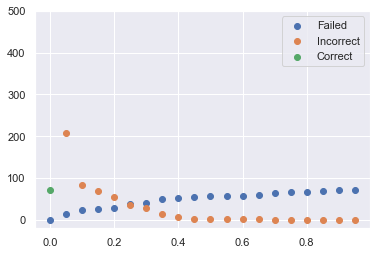

In [642]:
# Plot the outcomes of predictions for each tested threshold
plt.scatter(vals, failed, label='Failed')
plt.scatter(vals, incorrect, label='Incorrect')
plt.scatter(vals, correct, label='Correct')
plt.ylim([-20, 500])
#plt.ylim([3700, 4000])
plt.legend()

(0.965, 0.995)

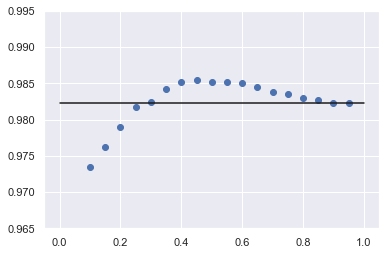

In [643]:
# Plot the accuracy of the model for each tested threshold
percent = [k/len(ypredict_binary) for k in correct]
plt.scatter(vals, percent)
plt.plot([0, 1], [fraction_not_fatal, fraction_not_fatal], c='k')
plt.ylim([0.965, 0.995])

Based on these tests, it would seem that a threshold of around 0.45 is the best
most accurate and thus the best for distinguishing fatal events from non-fatal 
events. We'll test this idea below.

## Part 4: Predictions

Using the model we created above, we can now attempt to predict the likelihood 
of a fatality for each EF category given county demographic data.

In [566]:
# Generate a hypothetical scenario to input into the model.
ranks = []
for i in range(0, 6, 1):
    example = pd.DataFrame(columns=['EF_Rate', 'EP_MOBILE', 
                        'Density', 'DJF', 'MAM', 'JJA', 'SON', 'NIGHT'])
    #example.RPL_THEMES = [0.8]
    example.EF_Rate = [i]
    #example.EP_MOBILE = [cdc_test.EP_MOBILE.mean()]
    example.EP_MOBILE = [10]
    #example.Density = [cdc_test.Density.mean()]
    example.Density = [60000/520]
    example.DJF = [1]
    example.MAM = [0]
    example.JJA = [0]
    example.SON = [0]
    example.NIGHT = [1]
    out = forest.predict(example)
    ranks.append(out)

(0.0, 1.0)

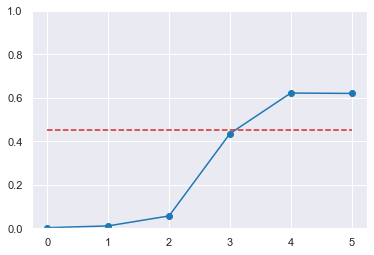

In [567]:
# Generate a plot of likelihood of a fatality for each EF category
plt.plot([0, 1, 2, 3, 4, 5], ranks, c='tab:blue')
plt.scatter([0, 1, 2, 3, 4, 5], ranks, c='tab:blue')
plt.plot([0, 5], [0.45, 0.45], c='tab:red', linestyle='--')
plt.ylim([0, 1])

Now, let's run a prediction on an actual tornado that occurred outside of our 
dataset (more recently than the NCEI data used).

In [568]:
# North of Montgomery, AL (Elmore County) [11/29/22]
ranks = []
for i in range(0, 6, 1):
    example = pd.DataFrame(columns=['EF_Rate', 'EP_MOBILE', 
                        'Density', 'DJF', 'MAM', 'JJA', 'SON', 'NIGHT'])
    example.EF_Rate = [i]
    example.EP_MOBILE = [15.1]
    example.Density = [89304/657]
    example.DJF = [0]
    example.MAM = [0]
    example.JJA = [0]
    example.SON = [1]
    example.NIGHT = [1]
    out = forest.predict(example)
    ranks.append(out)

(0.0, 1.0)

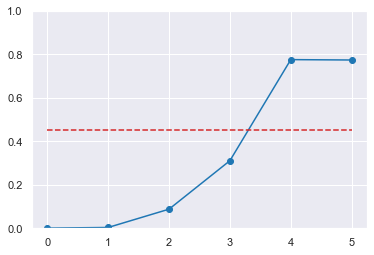

In [569]:
# Generate a plot of likelihood of a fatality for each EF category
plt.plot([0, 1, 2, 3, 4, 5], ranks, c='tab:blue')
plt.scatter([0, 1, 2, 3, 4, 5], ranks, c='tab:blue')
plt.plot([0, 5], [0.45, 0.45], c='tab:red', linestyle='--')
plt.ylim([0, 1])

Note that in this example, an EF2 tornado resulted in two fatalities, 
demonstrating a major limitation of this model: low-end events. Though EF2 and 
below tornadoes do sometimes result in fatalities, it is virtually impossible 
for this category to reach the 0.45 threshold.

One possible solution would be to plot the range of values for each EF category 
as a boxplot and overlay predictions for the specified event, thus highlighting 
higher end events more clearly for each category.

In [619]:
# Make a copy of the Xtest dataframe
idea = Xtest

In [620]:
# Add two new columns: the fatality column that we removed to run our model and 
# the predicted values we generated with our model.
idea['fatal'] = ytest
idea['predictions'] = ypredict

In [621]:
# Subset just the tornadoes which did have fatalities
idea2 = idea[idea['fatal']==1]

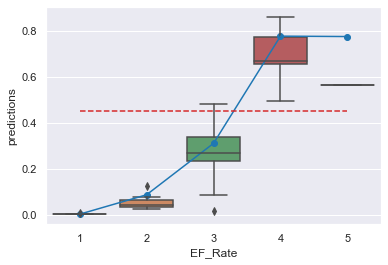

In [624]:
# Plot our model output line from above over top of a histogram of model 
# predictions for the entire test dataset.
sns.boxplot(x=idea2.EF_Rate, y=idea2.predictions)
plt.plot([0, 1, 2, 3, 4], ranks[1:], c='tab:blue')
plt.scatter([0, 1, 2, 3, 4], ranks[1:], c='tab:blue')
plt.plot([0, 4], [0.45, 0.45], c='tab:red', linestyle='--')

Now we can see that even though our EF2 value is below our 0.45 threshold, it 
is still in the upper end of EF2 predictions that did in fact result in 
fatalities. We can also see an obvious limitation in our testing dataset. There 
are no EF0 fatalities and only one EF5 fatality included.

Let's also compare these values to a histogram of predictions for tornadoes that did not have fatalities...

In [625]:
# Subset just the tornadoes which did not have fatalities
idea3 = idea[idea['fatal']==0]

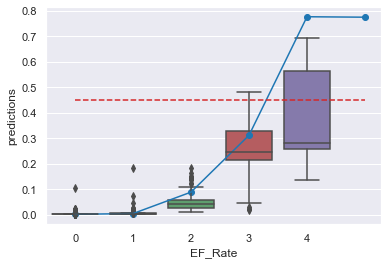

In [626]:
# Plot our model output line from above over top of a histogram of model 
# predictions for the entire test dataset.
sns.boxplot(x=idea3.EF_Rate, y=idea3.predictions)
plt.plot([0, 1, 2, 3, 4, 5], ranks, c='tab:blue')
plt.scatter([0, 1, 2, 3, 4, 5], ranks, c='tab:blue')
plt.plot([0, 5], [0.45, 0.45], c='tab:red', linestyle='--')

Comparing the two histograms (rather than the line plots on top of them, we see 
something interesting). For EF3 and below, there do not appear to be meaningful 
differences between the two graphs, suggesting that the model does a poor job 
at distinguishing whether these tornadoes will be deadly. However, we see a 
major difference in the EF4 category with predictions of fatal storms being 
significantly higher than those of non-fatal storms.

This seems to suggest that the model is far better at predicting whether 
high-end tornadoes will result in fatalities as opposed to low-end tornadoes.

In [627]:
ef4_fatal = idea2[idea2['EF_Rate']==4]
ef4_nonfatal = idea3[idea3['EF_Rate']==4]

print(f'Fatal EF4s: {len(ef4_fatal)}')
print(f'Non-fatal EF4s: {len(ef4_nonfatal)}')

Fatal EF4s: 14
Non-fatal EF4s: 6


It is, however, important to include a caveat that the sample size here is 
incredibly small, both for fatal and non-fatal EF4s.

## Part 5: Saving the Model

Lastly, we can save our model, ensuring that any future testing will yield 
identical results (as re-running the regressor could result in slightly 
different values depending on how the dataset is split). This will also allow 
for the model to be easily read into other notebooks.

In [270]:
import joblib
import os

In [561]:
# Save our current random forest regressor
joblib.dump(forest, "./random_forest_new.joblib")

['./random_forest_new.joblib']

If we wanted to load this model in, we would simply run the following cell.

In [273]:
# Load a saved model back in
loaded_model = joblib.load("./random_forest_new.joblib")

### Limitations and Final Thoughts

This model seems to have fulfilled it's intended purpose fairly well as we were 
able to assign importances to a number of variables that potentially contribute 
to whether a tornado will result in a fatality.

In terms of using this model to predict tornado fatalities, results were very 
mixed. The model seems to do well with higher-end events (with some major 
caveats), but performs much more poorly with lower-end events. This is likely 
because of the extremely random nature of tornado fatalities. Although we can 
see patterns in the data, there is a certain amount of random chance and 
factors at scales smaller than the county level as well. For example, we cannot 
see from county-level data whether a given tornado tracked through an open 
field or a dense mobile home park, we only have broad statistics regarding the 
density of people in the entire county and the percentage of homes that are 
mobile homes.

We could potentially improve the model by utilizing the census tract level data 
from the CDC rather than county data, but this would still not reduce the 
unpredictable random noise (like whether a given person went to their basement 
or not). Thus, although this project shows that there is some ability to 
predict tornado fatalities using machine learning, it seems likely that, at 
least for the moment, making highly accurate predictions is nearly impossible.

--------------------------

### Random Ideas...

In [628]:
bad_predictions = forest.predict(Xtrain)

In [629]:
bad_idea = Xtrain

In [630]:
# Add two new columns: the fatality column that we removed to run our model and 
# the predicted values we generated with our model.
bad_idea['fatal'] = ytrain
bad_idea['predictions'] = bad_predictions

In [631]:
bad_idea2 = bad_idea[bad_idea['fatal']==1]

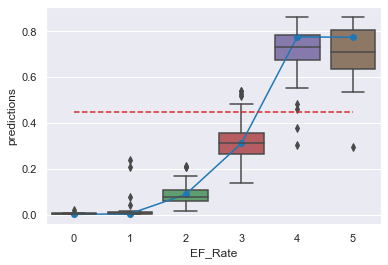

In [632]:
sns.boxplot(x=bad_idea2.EF_Rate, y=bad_idea2.predictions)
plt.plot([0, 1, 2, 3, 4, 5], ranks, c='tab:blue')
plt.scatter([0, 1, 2, 3, 4, 5], ranks, c='tab:blue')
plt.plot([0, 5], [0.45, 0.45], c='tab:red', linestyle='--')

In [633]:
bad_idea3 = bad_idea[bad_idea['fatal']==0]

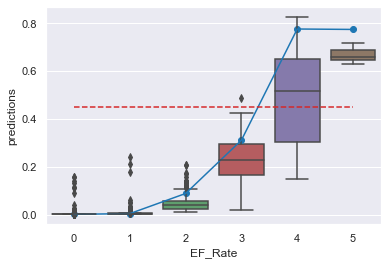

In [634]:
sns.boxplot(x=bad_idea3.EF_Rate, y=bad_idea3.predictions)
plt.plot([0, 1, 2, 3, 4, 5], ranks, c='tab:blue')
plt.scatter([0, 1, 2, 3, 4, 5], ranks, c='tab:blue')
plt.plot([0, 5], [0.45, 0.45], c='tab:red', linestyle='--')

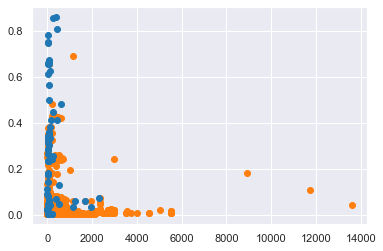

In [646]:
plt.scatter(idea3.Density, idea3.predictions, c='tab:orange')
plt.scatter(idea2.Density, idea2.predictions, c='tab:blue')

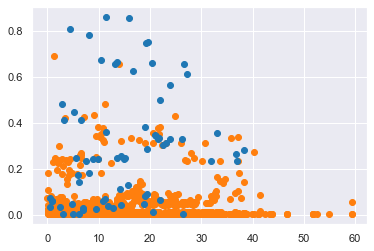

In [648]:
plt.scatter(idea3.EP_MOBILE, idea3.predictions, c='tab:orange')
plt.scatter(idea2.EP_MOBILE, idea2.predictions, c='tab:blue')

<AxesSubplot:xlabel='DJF', ylabel='predictions'>

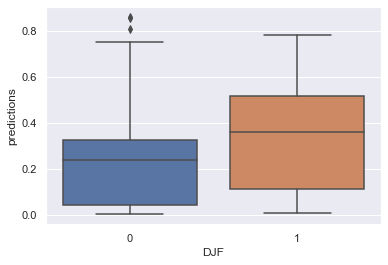

In [653]:
sns.boxplot(x=idea2.DJF, y=idea2.predictions)

<AxesSubplot:xlabel='DJF', ylabel='predictions'>

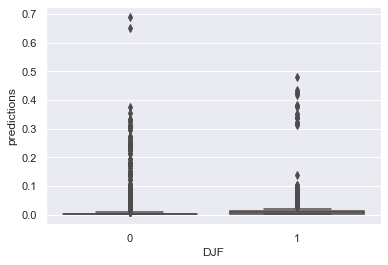

In [657]:
sns.boxplot(x=idea3.DJF, y=idea3.predictions)

<AxesSubplot:xlabel='NIGHT', ylabel='predictions'>

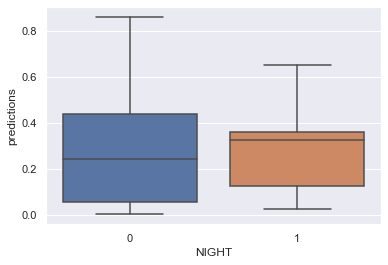

In [658]:
sns.boxplot(x=idea2.NIGHT, y=idea2.predictions)

<AxesSubplot:xlabel='NIGHT', ylabel='predictions'>

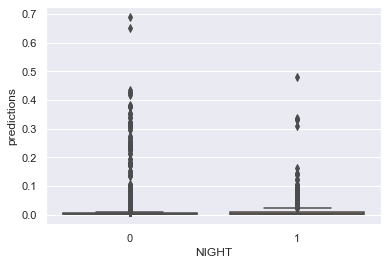

In [659]:
sns.boxplot(x=idea3.NIGHT, y=idea3.predictions)